Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [1]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
#interactive plotting in separate window
%matplotlib qt 
# %matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
from utils import save_data, load_data
import time

## Folder dir for saving and loading files

In [2]:
# model_name = 'psm'
model_name = 'psm_simplified'
save_name = 'psm_si_test_simplified'

# model_folder = 'data/' + model_name + '/model/'
model_folder = 'data/' + save_name + '/model/'

---
# 2 - Robot modelling

## Robot geometry definition in following order

Joint number | prev link | succ links | $a$ | $\alpha$ | $d$ | $\theta$ | link inertia | motor inertia | friction 

In [3]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = new_sym('q:11')
_pi = sympy.pi

dh = []
springs = []
friction_type = []

if (model_name == 'psm_simplified'):
    # define paralelogram coordinate relation
    # qd -> coordinate for dvrk_ros package
    # qmd -> coordinate for the modeling joints
    # q -> coordinate for motors
    qmd5 = 1.0186 * q5
    qmd6 = -0.8306 * q5 + 1.2178 * q6
    qmd7 = -0.8306 *q5 + 1.2178 * q7
    
    l_2L1 = 96*0.001
    l_2L2 = 516*0.001
    l_2L3 = 40.09*0.001
    
    l_2H1 = 144.54*0.001
    l_2H2 = 38.08*0.001
    
    l_3 = 40.09*0.001
    
    l_RCC = 431.8*0.001
    l_tool = 416.2*0.001
    l_p2y = 9.1*0.001
    
    M_motor2dvrk_q = np.matrix([[1.0186, 0, 0], [-0.8306, 0.6089, 0.6089], [0, -1.2177, 1.2177]])
    M_model2dvrk_q = np.matrix([[1, 0, 0], [0, 0.5, 0.5], [0, -1, 1]])
    
    L_b = 0
    L_1 = 1
    L_20 = 2
    L_21 = 3
    L_22 = 4
    L_23 = 5
    L_24 = 6
    L_25 = 7
    L_30 = 8
    L_31 = 7
    L_4 = 9
    L_5 = 10
    L_6 = 11
    L_7 = 12
    M_6 = 13
    M_7 = 14
    F_67 = 15
    
    # define spring delta L
    dlN = None

    dl4 = -q4
    
    
    l1 = 8*0.0254*0.891
    l2 = 8*0.0254*0.454
    l3 = 15.5*0.0254*0.983
    l4 = 15.5*0.0254*0.181
    
    x = [None]*16
    x[0]  = (L_b,  -1,   [L_1, M_6, M_7, F_67], 0,           0,      0,              0,          False, False, False, dlN) # Base
    
    x[1]  = (L_1,  L_b,  [L_20],                0,           _pi/2,  0,              q1+_pi/2,   True,  False, True,  dlN) # Yaw
    x[2]  = (L_20, L_1,  [L_21],                -0.07,           -_pi/2, 0,              _pi/2,   False,  False, False ,  dlN) # -- Intermediate
    x[3]  = (L_21, L_20, [L_22],                0.29,       0,      0,              -_pi/2 + q2,      True, False, True, dlN) # Pitch Back
    x[4]  = (L_22, L_21, [L_23],                l1,       _pi/2,      l2,             0,      False, False, False, dlN) # Pitch Back
    x[5]  = (L_23, L_22, [L_24],                      0,       -_pi/2,      0,              _pi/2 - q2,  True,  False, False, dlN) # Pitch Front
    x[6]  = (L_24, L_23, [L_25],                      l3,       _pi/2,      l4,              0,  False,  False, False, dlN) # Pitch Front  
    x[7]  = (L_25, L_24, [L_30],                      0,       -_pi/2,      0,              q2,  True,  False, False, dlN) # Pitch Front
    x[8]  = (L_30, L_25, [L_4],                      3.568*0.0254,       -_pi/2,     (-5.352*0.0254+q3),             0,  True,  False, False, dlN) # Pitch Front
    
    # #x[5]  = (L_23, L_21, [],                    l_2H1+l_2H2, 0,      0,              -q2+_pi/2, True,  False, False, dlN)    # Intermediate
    # x[5]  = (L_24, L_22, [L_30],                l_2L2,       0,      0,              q2,         True,  False, False, dlN)    # Pitch Bottom
    # #x[7]  = (L_25, L_22, [],                    l_2L1,       0,      0,              q2+_pi,    True,  False, False, dlN)    # Pitch Top
    # x[6]  = (L_30, L_24, [L_4],                 l_3,         -_pi/2, q3-l_RCC+l_2H1, 0,          True,  False, True,  dlN)    # Pitch End
    # x[7]  = (L_31, L_20, [],                    l_2L3,       -_pi/2, q3,             0,          True,  False, False, dlN)    # Main Insertion
    
    x[9] = (L_4,  L_30, [L_5],                  0,           0,      l_tool,         q4,         False, True,  True,  dl4) # Intermediate Counterweight
    x[10] = (L_5,  L_4,  [L_6, L_7],             0,           _pi/2,  0,              qmd5+_pi/2, False, True,  True,  dlN) # Counterweight
    x[11] = (L_6,  L_5,  [],                    l_p2y *0.5,       -_pi/2, 0,              qmd6+_pi/2, False, False, True,  dlN) # Tool Roll 
    x[12] = (L_7,  L_5,  [],                    l_p2y *0.5,       -_pi/2, 0,              qmd7+_pi/2, False, False, True,  dlN) # Tool Pitch

    x[13] = (M_6,  L_b,  [],                    0,           0,      0,              q6,         False, True,  True,  dlN) # Tool Yaw1 inert
    x[14] = (M_7,  L_b,  [],                    0,           0,      0,              q7,         False, True,  True,  dlN) # Tool Yaw2 inert
    x[15] = (F_67, L_b,  [],                    0,           0,      0,              qmd7-qmd6,  False, False, True,  dlN) # q6 q7 coupled friction
    
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']
    print(model_name)
elif (model_name == 'psm'):
    # define paralelogram coordinate relation
    # qd -> coordinate for dvrk_ros package
    # qmd -> coordinate for the modeling joints
    # q -> coordinate for motors
    qmd5 = 1.0186 * q5
    qmd6 = -0.8306 * q5 + 1.2178 * q6
    qmd7 = -0.8306 *q5 + 1.2178 * q7
    
    l_2L1 = 96*0.001
    l_2L2 = 516*0.001
    l_2L3 = 40.09*0.001
    
    l_2H1 = 144.54*0.001
    l_2H2 = 38.08*0.001
    
    l_3 = 40.09*0.001
    
    l_RCC = 431.8*0.001
    l_tool = 416.2*0.001
    l_p2y = 9.1*0.001
    
    M_motor2dvrk_q = np.matrix([[1.0186, 0, 0], [-0.8306, 0.6089, 0.6089], [0, -1.2177, 1.2177]])
    M_model2dvrk_q = np.matrix([[1, 0, 0], [0, 0.5, 0.5], [0, -1, 1]])
    
    # define link number
    L_b = 0
    L_1 = 1
    L_20 = 2
    L_21 = 3
    L_22 = 4
    L_23 = 5
    L_24 = 6
    L_25 = 7
    L_30 = 8
    L_31 = 9
    L_4 = 10
    L_5 = 11
    L_6 = 12
    L_7 = 13
    M_6 = 14
    M_7 = 15
    F_67 = 16
    
    # define spring delta L
    dlN = None

    dl10 = -q4
    
    x = [None]*17
    x[0]  = (L_b,  -1,   [L_1, M_6, M_7, F_67], 0,           0,      0,              0,          False, False, False, dlN) # Base
    
    
    x[1]  = (L_1,  L_b,  [L_20],                0,           _pi/2,  0,              q1+_pi/2,   True,  False, True,  dlN) # Yaw
    x[2]  = (L_20, L_1,  [L_21, L_31],          0,           -_pi/2, 0,              q2-_pi/2,   True,  False, True,  dlN) # -- Intermediate
    x[3]  = (L_21, L_20, [L_22, L_23],          l_2L3,       0,      0,              _pi/2,      False, False, False, dlN) # Pitch Back
    x[4]  = (L_22, L_21, [L_24, L_25, L_30],    l_2H1,       0,      0,              -q2+_pi/2,  True,  False, False, dlN) # Pitch Front                                    )
    x[5]  = (L_23, L_21, [],                    l_2H1+l_2H2, 0,      0,              -q2+_pi/2,  True,  False, False, dlN)    # Intermediate
    x[6]  = (L_24, L_22, [L_30],                l_2L2,       0,      0,              q2,         True,  False, False, dlN)    # Pitch Bottom
    x[7]  = (L_25, L_22, [],                    l_2L1,       0,      0,              q2+_pi,     True,  False, False, dlN)    # Pitch Top
    x[8]  = (L_30, L_24, [L_4],                 l_3,         -_pi/2, q3-l_RCC+l_2H1, 0,          True,  False, True,  dlN)    # Pitch End
    x[9]  = (L_31, L_20, [],                    l_2L3,       -_pi/2, q3,             0,          True,  False, False, dlN)    # Main Insertion
    x[10] = (L_4,  L_30, [L_5],                 0,           0,      l_tool,         q4,         False, True,  True,  dl10) # Intermediate Counterweight
    x[11] = (L_5,  L_4,  [L_6, L_7],            0,           _pi/2,  0,              qmd5+_pi/2, False, True,  True,  dlN) # Counterweight
    x[12] = (L_6,  L_5,  [],                    l_p2y,       -_pi/2, 0,              qmd6+_pi/2, False, False, True,  dlN) # Tool Roll 
    x[13] = (L_7,  L_5,  [],                    l_p2y,       -_pi/2, 0,              qmd7+_pi/2, False, False, True,  dlN) # Tool Pitch
    
    x[14] = (M_6,  L_b,  [],                    0,           0,      0,              q6,         False, True,  True,  dlN) # Tool Yaw1 inert
    x[15] = (M_7,  L_b,  [],                    0,           0,      0,              q7,         False, True,  True,  dlN) # Tool Yaw2 inert
    x[16] = (F_67, L_b,  [],                    0,           0,      0,              qmd7-qmd6,  False, False, True,  dlN) # q6 q7 coupled friction
    
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']
    print(model_name)
else:
    raise Exception("No robot name matches " + model_name)
print(friction_type)
robot_def = RobotDef(dh, dh_convention='mdh', friction_type=friction_type)

psm_simplified
['Coulomb', 'viscous', 'offset']


In [5]:
M_motor2dvrk_q = np.matrix([[1.0186, 0, 0], [-0.8306, 0.6089, 0.6089], [0, -1.2177, 1.2177]])
M_model2dvrk_q = np.matrix([[1, 0, 0], [0, 0.5, 0.5], [0, -1, 1]])
M_motor2model_q = np.linalg.inv(M_model2dvrk_q)*M_motor2dvrk_q
M_motor2model_q[np.abs(M_motor2model_q) < 0.0001] = 0
M_motor2model_q

matrix([[ 1.0186 ,  0.     ,  0.     ],
        [-0.8306 ,  1.21775,  0.     ],
        [-0.8306 ,  0.     ,  1.21775]])

In [6]:
robot_def.coordinates_joint_type

['R', 'R', 'P', 'R', 'R', 'R', 'R']

In [7]:
robot_def.bary_params

## Create kinematics chain

In [8]:
%time geom = Geometry(robot_def)

Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12
Frame: 13
Frame: 14
Frame: 15
CPU times: user 9min 34s, sys: 2min 47s, total: 12min 21s
Wall time: 12min 21s


In [89]:
angle = [0, 0.0, 0, 0, 0, 0, 0]
geom.draw_geom(angle)

## Create dynamics

In [10]:
%time dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating the link kinetic energy of 1/15
Calculating the link kinetic energy of 3/15
Calculating the link kinetic energy of 5/15
Calculating the link kinetic energy of 7/15
Calculating the link kinetic energy of 8/15
Calculating joint torques...
tau of q1
tau of q2
tau of q3
tau of q4
tau of q5
tau of q6
tau of q7
Adding frictions and springs...
Add motor inertia...
Calculating regressor...
Calculating M, C and G...
Calculating base parameter...
base parameter number: 45
Creating H_b function...
Finished creating robot dynamics
CPU times: user 9.35 s, sys: 2.82 s, total: 12.2 s
Wall time: 9.39 s


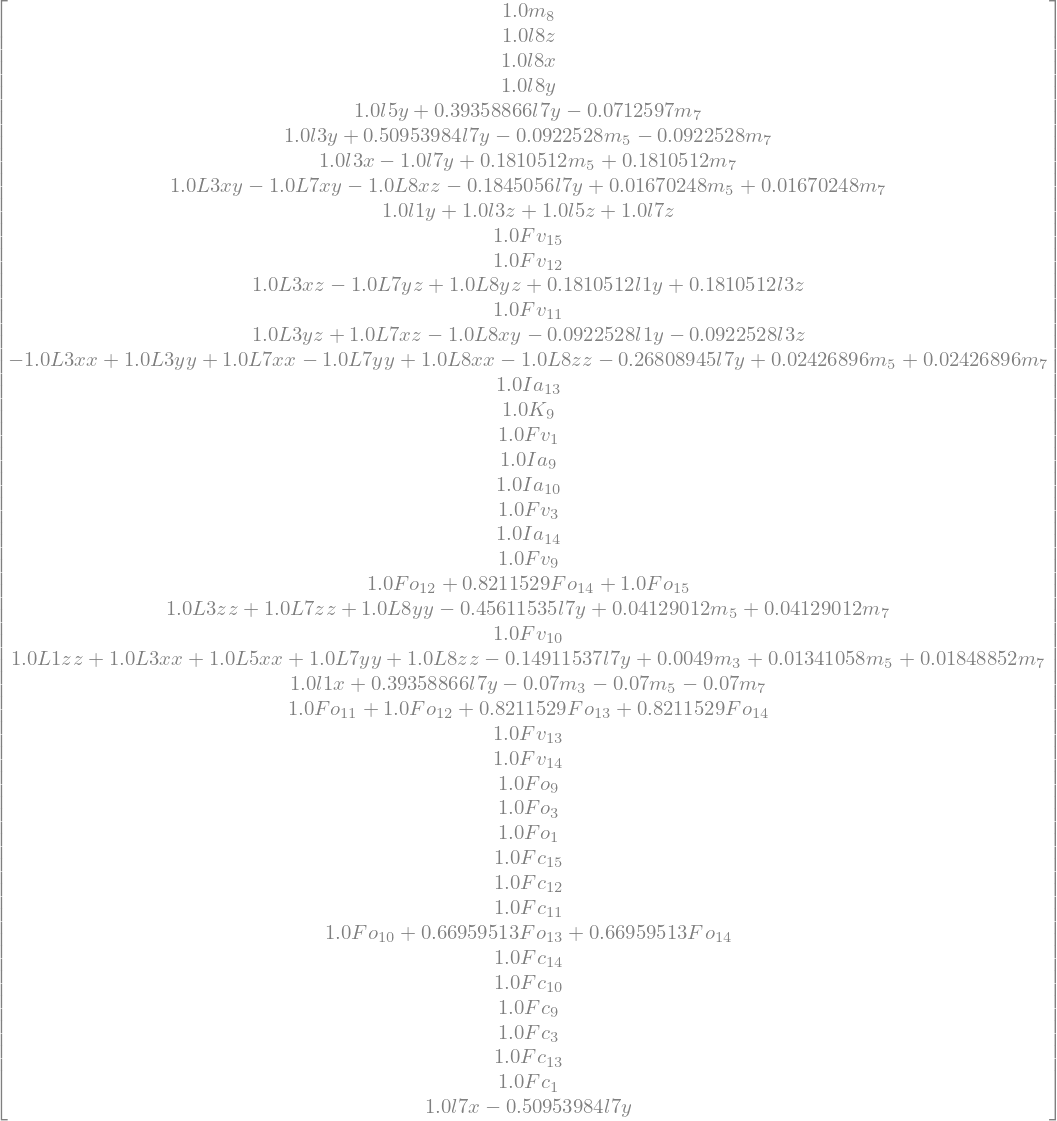

In [79]:
sympy.Matrix(dyn.base_param)

In [12]:
from data import RobotModel

# Data to be saved
robot_model = RobotModel(dyn)

# Save
save_data(model_folder, model_name, robot_model)
print('Saved {} parameters'.format(len(robot_model.base_param)))

Saved 45 parameters


---
# 3 - Excitation trajectory optimization

In [24]:
model_name = 'psm_simplified'
# model_name = 'psm'

Load Data

In [25]:
from utils import load_data
save_name = 'psm_si_test_simplified'
# model_folder = 'data/' + model_name + '/model/'
model_folder = 'data/' + save_name + '/model/'
robot_model = load_data(model_folder, model_name)

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [31]:
trajectory_name = 'si_two'
#trajectory_name = 'three'
# trajectory_name = 'four'
# trajectory_name = 'five'

In [27]:
from numpy import deg2rad

optimal_trajectory_folder = 'data/optimal_trajectory/'
# trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
trajectory_folder = 'data/' + save_name +'/optimal_trajectory/'

base_freq = 0.18
fourier_order = 6

joint_constraints = []
cartesian_constraints = []

if model_name == 'psm_simplified':
# if model_name == 'psm':
    q_dvrk7 = 1.2177*q7 - 1.2177*q6
#     q_mod6 = (4871*q6)/4000 - (4153*q5)/5000
#     q_mod7 = - (4153*q5)/5000 + (4871*q7)/4000
    
    q_dvrk5 = 1.0186 * q5
    q_mod6 = -0.8306 * q5 + 1.2178 * q6
    q_mod7 = -0.8306 * q5 + 1.2178 * q7
    
    joint_constraints = [(q1, -2.6, 2.6, -1.0, 1.0),
                         (q2, -0.85, 1.0, -1.2, 1.2),
                         (q3,0.07,0.235,-0.35,0.35),
                         (q4,-1.5,1.5,-2,2),
                         (q_dvrk5,-1.4,1.4,-2,2), 
                         (q_dvrk7, 0.15, 3,-3,3),
                         (q_mod7, -1.5, 1.5,-2,2),
                          (q_mod6, -1.5, 1.5,-2,2)]
else:
    raise Exception("No robot name matches " + model_name)
    
traj_optimizer = TrajOptimizer(robot_model, fourier_order, base_freq,
                               joint_constraints=joint_constraints,
                               cartesian_constraints = cartesian_constraints)
                                                                                                 
                                                                                                                     
traj_optimizer.optimize()


joint constraint number: 8
cartesian constraint number: 0
constraint number: 32
frames_constrained: []




   ---------------------------------------------------------------------------
     START OF THE SEQUENTIAL LEAST SQUARES PROGRAMMING ALGORIT  
   ---------------------------------------------------------------------------

     PARAMETERS:
        ACC =   0.1000D-05
        MAXITER = 50
        IPRINT =   0
IOUT =   6


Condition number: 87.80598756910197
Condition number: 87.8059875701039


     ITER =    1     OBJ =  0.74632455E+02
      0.4825E+00
      0.2367E+01
      0.4487E-02
      0.6661E-01
      0.1789E+01
      0.2110E+01
      0.7253E+00
      0.5169E+00
      0.1108E+00
      0.1282E+01
      0.2010E+01
      0.3985E+00
      0.3245E+00
      0.1821E+00
      0.1106E+01
      0.1410E+01
      0.2650E+01
      0.2486E+01
      0.2658E+00
      0.2577E+01
      0.2325E+01
      0.1985E+01
      0.7488E+00
      0.4688E+00
      0.1023E+01
      0.2225E+01
      0.6288

In [28]:
reg_norm_mat = traj_optimizer.calc_normalize_mat()

## Plot optimal excitation trajectory

In [29]:
traj_optimizer.calc_frame_traj()

In [30]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj,traj_optimizer.frame_traj,
                           traj_optimizer.const_frame_ind, robot_model.coordinates)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

traj_plotter.plot_frame_traj(True)

## Save trajectory for later use

In [32]:
dof_order_bf_x_norm = (traj_optimizer.fourier_traj.dof, fourier_order,
                       base_freq, traj_optimizer.x_result, reg_norm_mat)
save_data(trajectory_folder, trajectory_name, dof_order_bf_x_norm)

In [34]:
from IPython.display import HTML, display
import tabulate

table = []
table.append(["joint", 'qo'] +
             ["a"+str(i+1) for i in range(fourier_order)] +
             ["b"+str(i+1) for i in range(fourier_order)])
for i in range(traj_optimizer.fourier_traj.dof):
    line = []
    line.append(robot_model.coordinates[i])
    line += np.round(traj_optimizer.x_result[i*(1 + fourier_order*2): (i+1)*(1 + fourier_order*2)], 4).tolist()
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

joint,qo,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
q1,-0.0747,-0.0328,-0.0499,-0.0869,-0.1186,-0.0365,-0.1069,-0.0116,-0.0356,-0.1116,-0.3234,-0.8443,0.4005
q2,0.2677,-0.2553,-0.5166,0.3376,-0.4247,0.0752,-0.0404,0.8317,0.6492,-0.1087,-0.0282,0.1263,-0.0742
q3,0.1446,-0.0001,0.0223,-0.0613,-0.0878,-0.0258,0.1559,0.0478,-0.0306,0.024,0.025,-0.1075,0.0188
q4,0.1629,-0.0353,-0.0447,-0.4101,-0.1149,-0.0848,-0.4798,0.5918,-0.0748,0.0099,0.0046,-0.1333,-0.4689
q5,0.2544,0.0482,-1.0477,-0.2752,0.0344,0.135,0.1913,-0.0331,0.3507,-0.1598,0.2735,-0.0539,-0.5969
q6,-0.5188,-0.0435,-0.7773,-0.6003,-0.2596,-0.024,0.3685,-0.0977,0.2649,-0.28,-0.3552,-0.2317,-0.4126
q7,0.6984,-0.2165,-1.0473,-0.2378,-0.0682,-0.8292,0.1884,0.343,0.512,-0.0307,-0.0766,-0.3942,-0.3957


---
# Data processing

## Load data

In [35]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor
from identification.data_processing import raw_data_cut

### Load robot model

In [36]:
# Names as Arguments
model_name = 'psm_simplified'
save_name = 'psm_si_test_simplified'
training_trajectory_name = 'si_one'


# model_folder = 'data/' + model_name + '/model/'
model_folder = 'data/' + save_name + '/model/'
robot_model = load_data(model_folder,model_name)


# trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
trajectory_folder = 'data/' + save_name +'/optimal_trajectory/'
dof, fourier_order, base_freq, traj_optimizer_result, reg_norm_mat = load_data(trajectory_folder,
                                                                          training_trajectory_name)
#dof, fourier_order, base_freq, traj_optimizer_result = load_data(trajectory_folder,training_trajectory_name)
     
print("dof: {}".format(dof))
print("Fourier order: {}".format(fourier_order))
print("Base frequency: {}".format(base_freq))

dof: 7
Fourier order: 6
Base frequency: 0.18


### Load traning data set

In [37]:
# training_trajectory_name = 'one'
# results_folder = 'data/' + model_name +'/measured_trajectory/'
results_folder = 'data/' + save_name +'/measured_trajectory/'
# training_results_data_file = '../force_estimation/simon_trocar_mar_6/free_space_needle/fs_free_space_needle_int_w_jaw.csv'
training_results_data_file = 'data_preprocess/free_train_si_0.csv'

trajectory_sampling_rate = 200
t_train, q_raw_train, dq_raw_train, tau_raw_train = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)

<class 'numpy.ndarray'> (29782, 21)


### Training trajectory

In [38]:
from trajectory_optimization import FourierTraj
fourier_traj_train = FourierTraj(dof, fourier_order, base_freq, sample_num_per_period=20)
traj_plotter_train = TrajPlotter(fourier_traj_train, coordinates=robot_model.coordinates)
traj_plotter_train.plot_desired_traj(traj_optimizer_result)

/home/simon/daVinci_dynamic_identification/trajectory_optimization/traj_plotter.py:105: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


In [39]:
import pandas as pd
        
# train_wpi_1 = pd.read_csv('data/psm_test_simplified/measured_trajectory/free_train_jhu_1.csv')
train_wpi_1 = pd.read_csv('data_preprocess/free_train_si_0.csv')
train_wpi_1

,0.1459488196666303,-0.7278206456941526,0.11953909742282012,-0.2382102133349036,0.2126539586698436,-0.28657563471856334,-0.00010416223026687987,-1.6041421812419675e-06,-3.98575805214431e-06,2.5583439774626625e-07,...,0.0.1,0.0.2,0.0.3,-0.9231195171245096,3.322800348825952,-5.6896928536453695,0.03250966764419956,0.04282856365069253,0.041584833914757216,-0.027324066263361407
0,0.145949,-0.727821,0.119539,-0.238210,0.212654,-0.286576,-0.000104,-0.000002,-0.000004,2.552050e-07,...,0.000000,0.000000,0.000000,-0.921026,3.323868,-5.694341,0.032531,0.042772,0.041549,-0.027306
1,0.145949,-0.727821,0.119539,-0.238210,0.212654,-0.286576,-0.000104,-0.000002,-0.000004,2.548594e-07,...,0.000000,0.000000,0.000000,-0.922073,3.323868,-5.703638,0.032488,0.042897,0.041694,-0.027233
2,0.145949,-0.727821,0.119539,-0.238210,0.212654,-0.286576,-0.000104,-0.000002,-0.000004,2.545508e-07,...,0.000000,0.000000,0.000000,-0.921026,3.322800,-5.692017,0.032488,0.042829,0.041585,-0.027324
3,0.145949,-0.727821,0.119539,-0.238210,0.212654,-0.286576,-0.000104,-0.000002,-0.000004,2.538720e-07,...,0.000000,0.000000,0.000000,-0.923120,3.322800,-5.698990,0.032510,0.042795,0.041585,-0.027215
4,0.145949,-0.727821,0.119539,-0.238210,0.212654,-0.286576,-0.000104,-0.000002,-0.000004,2.535264e-07,...,0.000000,0.000000,0.000000,-0.921026,3.323868,-5.698990,0.032488,0.042772,0.041549,-0.027306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29776,0.152400,-0.710654,0.119450,-0.215811,0.214019,-0.284103,-0.009479,-0.163471,-0.417499,3.106823e-03,...,-0.197750,-0.236930,0.039969,-1.399447,3.837485,-6.001138,-0.107161,-0.045774,-0.052217,-0.021935
29777,0.152297,-0.710918,0.119452,-0.215989,0.213905,-0.284291,-0.009583,-0.160265,-0.411042,3.033980e-03,...,-0.169986,-0.230983,-0.004974,-1.350244,4.120455,-6.001138,-0.106672,-0.051777,-0.060055,-0.024185
29778,0.152084,-0.711460,0.119456,-0.216167,0.213677,-0.284617,-0.009479,-0.156603,-0.401338,2.718470e-03,...,-0.135607,-0.235772,-0.005045,-1.290572,4.256067,-5.954654,-0.106863,-0.059123,-0.067385,-0.024367
29779,0.151980,-0.711728,0.119458,-0.216345,0.213564,-0.284753,-0.009479,-0.155229,-0.399991,2.912646e-03,...,-0.123047,-0.217975,-0.022384,-1.205775,4.343627,-5.945357,-0.106799,-0.058051,-0.064155,-0.023804


### Load test data set

In [40]:
# test_trajectory_name = 'two'

# results_folder = 'data/' + model_name +'/measured_trajectory/'
results_folder = 'data/' + save_name +'/measured_trajectory/'
# test_results_data_file = results_folder + test_trajectory_name + '_results.csv'
# test_results_data_file = '../force_estimation/simon_trocar_mar_6/free_space_needle/fs_free_space_needle_int_w_jaw.csv'
test_results_data_file = 'data_preprocess/free_train_si_0.csv'

trajectory_sampling_rate = 200
t_test, q_raw_test, dq_raw_test, tau_raw_test = load_trajectory_data(test_results_data_file,
                                                                   trajectory_sampling_rate)

<class 'numpy.ndarray'> (29782, 21)


## Calculate filter cut-off frequency

In [41]:
# times of the highest frequency in the Fourier series
#fc_mult = 4.0

fc_mult = [5] #(good)
#fc_mult = [8, 8, 5, 3, 4, 4, 4]

#fc_mult = 4
print(base_freq)
fc = np.array(fc_mult)*base_freq* fourier_order 

print(fc)


0.18
[5.4]


## Differentiation and filtering

### Traning data

In [42]:
t_cut_train, q_f_train, dq_f_train, ddq_f_train, tau_f_train, q_raw_cut_train, tau_raw_cut_train =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_train, q_raw_train, dq_raw_train, tau_raw_train, fc, fc, fc, fc, cut_num=1000)
# t_cut_train, q_f_train, dq_f_train, ddq_f_train, tau_f_train, q_raw_cut_train, tau_raw_cut_train = \
#     raw_data_cut(dof, 1.0/trajectory_sampling_rate, t_train, q_raw_train, dq_raw_train, tau_raw_train, cut_num=1000)
print(len(tau_raw_train))
print(len(q_raw_train))
print(len(tau_f_train))
plot_trajectory_data(t_cut_train, q_raw_cut_train, q_f_train, dq_f_train, ddq_f_train,
                     tau_raw_cut_train, tau_f_train)

q_raw shape: (29782, 7)
29782
29782
27782
plot shape: 470


### Test data

In [43]:
t_cut_test, q_f_test, dq_f_test, ddq_f_test,tau_f_test, q_raw_cut_test, tau_raw_cut_test =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_test, q_raw_test, dq_raw_test, tau_raw_test, fc, fc, fc, fc, cut_num=1000)
# t_cut_test, q_f_test, dq_f_test, ddq_f_test,tau_f_test, q_raw_cut_test, tau_raw_cut_test = \
#     raw_data_cut(dof, 1.0/trajectory_sampling_rate, t_test, q_raw_test, dq_raw_test, tau_raw_test, cut_num=1000)
plot_trajectory_data(t_cut_test, q_raw_cut_test, q_f_test, dq_f_test, ddq_f_test,
                     tau_raw_cut_test, tau_f_test)

q_raw shape: (29782, 7)
plot shape: 470


---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [44]:
base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b_train, tau_s_train = gen_regressor(base_param_num, H_b_func, q_f_train,
                                       dq_f_train, ddq_f_train, tau_f_train)

In [45]:
W_b_train.shape, tau_s_train.shape
#print np.linalg.cond(W_b_train)

In [46]:
xb_ols = np.linalg.lstsq(W_b_train, tau_s_train)[0]

/tmp/ipykernel_29605/594537227.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  xb_ols = np.linalg.lstsq(W_b_train, tau_s_train)[0]


In [47]:
#sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_ols))

from IPython.display import HTML, display
import tabulate

table = [["Base Parameter", "Value"]]

for i in range(robot_model.base_num):
    param_str = str(sympy.Matrix(robot_model.base_param)[i])
    max_disp_len = 350
    line = [param_str if len(param_str) <= max_disp_len 
            else param_str[:max_disp_len] + '...', xb_ols[i]]
    #['%.7s ...'%b if len(str(b)) > 7 else str(b)
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

Base Parameter,Value
1.0*m8,0.4166650975890644
1.0*l8z,-0.8468923062831761
1.0*l8x,-7.164751516130659
1.0*l8y,-4.465545640720452
1.0*l5y + 0.39358866*l7y - 0.0712597*m7,30.88202755343811
1.0*l3y + 0.50953984*l7y - 0.0922528*m5 - 0.0922528*m7,37.084434137868755
1.0*l3x - 1.0*l7y + 0.1810512*m5 + 0.1810512*m7,0.11563876331470568
1.0*L3xy - 1.0*L7xy - 1.0*L8xz - 0.1845056*l7y + 0.01670248*m5 + 0.01670248*m7,-5.542331214906465
1.0*l1y + 1.0*l3z + 1.0*l5z + 1.0*l7z,-6.875555929090348
1.0*Fv15,-0.001795329387664047


## Compare measured torque and predicted torque on the training set

### Generate predicted torque

In [48]:
tau_p_train = np.zeros(tau_f_train.shape)
tau_ps_train = W_b_train.dot(xb_ols)
for i in range(dof):
    tau_p_train[:, i] = tau_ps_train[i::dof]
    

### Evaluate regression

In [49]:
var_regression_error_ols = np.linalg.norm(tau_ps_train - tau_s_train) / \
                        (tau_ps_train.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols *
                                 np.linalg.inv(W_b_train.transpose().dot(W_b_train))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.002609716515767394
standard deviation of xb using OLS:
[8.91398606e-05 1.63348783e-03 1.27062093e-03 1.36013243e-03
 6.14487003e-02 6.63166936e-02 1.64049502e-03 1.17372790e-02
 4.70976294e-03 6.56884272e-04 1.39323545e-03 1.39775184e-03
 1.09770789e-03 1.10798610e-03 2.55790001e-02 1.91153848e-04
 7.81592321e-04 1.80879966e-03 7.47308065e-05 2.13080389e-04
 1.54115457e-03 8.74989515e-05 1.12999276e-03 2.54597879e-04
 1.27257480e-02 1.49650798e-03 1.23199378e-02 6.12958528e-02
 3.59958805e-04 1.53501388e-03 9.06987166e-03 3.36577613e-04
 1.94751634e-03 4.30664837e-02 3.94628292e-04 5.11065979e-04
 3.55993961e-04 4.20830285e-04 4.30590569e-04 7.42364217e-04
 4.64392215e-04 7.86229972e-04 6.63270139e-04 6.97012437e-04
 6.62358287e-02]
percentage of standard deviation of xb using OLS: 
[2.13936471e-04 1.92880230e-03 1.77343335e-04 3.04583704e-04
 1.98978841e-03 1.78826225e-03 1.41863763e-02 2.11775128e-03
 6.85001036e-04 3.65885100e-01 3.79116095e

### Plot measured torque and predicted torque

In [50]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
print(plot_data_num)
plot_meas_pred_tau(t_cut_train[:], tau_f_train[:, :],
                   tau_p_train[:, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

1111


## Compare measured torque and predicted torque on the test set

In [72]:
W_b_test, tau_s_test = gen_regressor(base_param_num, H_b_func, q_f_test,
                                       dq_f_test, ddq_f_test, tau_f_test)

tau_p_test = np.zeros(tau_f_test.shape)
tau_ps_test = W_b_test.dot(xb_ols)
for i in range(dof):
    tau_p_test[:, i] = tau_ps_test[i::dof]

In [73]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [74]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_test[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.16716163, 0.16928577, 0.56281801, 0.74288578, 0.38295037,
       0.34862725, 0.16452969])

## Weighted Least Square (WLS)

### Training data set

In [61]:
# weight = np.sqrt(np.linalg.norm(tau_f - tau_p, axis=0)/(tau_f.shape[0] - base_param_num))
weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)
weight

array([ 7.90247324, 23.58089378, 14.59898887,  0.26518169,  0.22559293,
        0.24882698,  0.03670224])

In [62]:
W_b_train.shape, tau_s_train.shape

In [63]:
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, int(W_b_train.shape[0]/weight.shape[0]))

In [64]:
W_b_wls_train = np.multiply(W_b_train, np.asmatrix(weights).transpose())
tau_s_wls_train = np.multiply(tau_s_train, weights)

In [65]:
xb_wls = np.linalg.lstsq(W_b_wls_train, tau_s_wls_train)[0]

/tmp/ipykernel_29605/2954463693.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  xb_wls = np.linalg.lstsq(W_b_wls_train, tau_s_wls_train)[0]


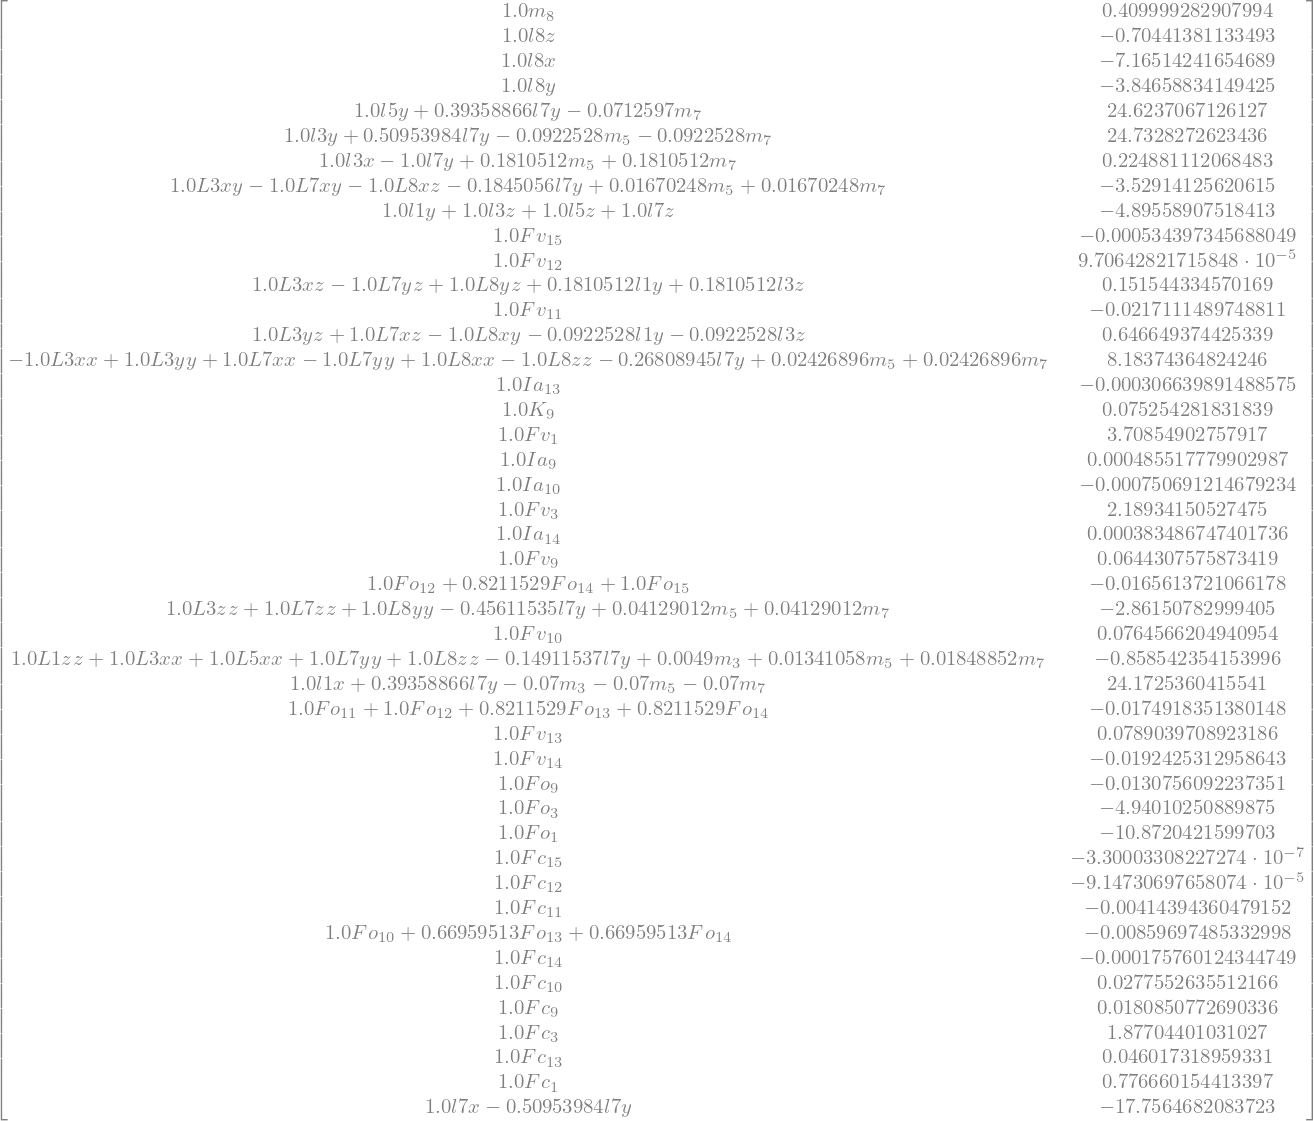

In [66]:
#np.set_printoptions(precision=2)
sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_wls))

In [67]:
tau_p_wls_train = np.zeros(tau_f_train.shape)
tau_ps_wls_train = W_b_train.dot(xb_wls)
for i in range(dof):
    tau_p_wls_train[:, i] = tau_ps_wls_train[i::dof]

In [68]:
plot_meas_pred_tau(t_cut_train[:], tau_f_train[:, :],
                   tau_p_wls_train[:, :],
                   robot_model.coordinates_joint_type, 
                   robot_model.coordinates)

In [70]:
np.linalg.norm(tau_f_train[:, :] - tau_p_wls_train[:, :], axis=0)\
    / np.linalg.norm(tau_f_train[:, :], axis=0)

array([0.18682198, 0.12680384, 0.6334533 , 0.5679165 , 0.38671387,
       0.42255715, 0.20393025])

### Test data set

In [75]:
weight = np.max(tau_f_test, axis=0) - np.min(tau_f_test, axis=0)

# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, int(W_b_test.shape[0]/weight.shape[0]))

W_b_wls_test = np.multiply(W_b_test, np.asmatrix(weights).transpose())
tau_s_wls_test = np.multiply(tau_s_test, weights)

tau_p_wls_test = np.zeros(tau_f_test.shape)
tau_ps_wls_test = W_b_test.dot(xb_wls)
for i in range(dof):
    tau_p_wls_test[:, i] = tau_ps_wls_test[i::dof]

plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_wls_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [76]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_wls_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.10958204, 0.28246052, 0.56929699, 0.74288578, 0.3807849 ,
       0.35069646, 0.15767078])

## Convex optimization

### Generate regressor matrix for barycentric parameters

In [80]:
from identification import SDPOpt

bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_train, tau_s_train = gen_regressor(bary_param_num, H_func,
                                     q_f_train, dq_f_train, ddq_f_train, tau_f_train)

In [81]:
W_w_train = np.multiply(W_train, np.asmatrix(weights).transpose())
tau_w_s_train = np.multiply(tau_s_train, weights)

min $m$, max $m$, min $r_x$, max $r_x$, min $r_y$, max $r_y$, min $r_z$, max $r_z$, max $F_c$, max $F_v$, max $F_o$, min $K$, max $K$

In [84]:
sdp_constraints = []
spring_constraints = []

if model_name == 'psm_simplified':
    sdp_constraints = [(0.3, 10, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1, 0.3, 0.5, 0.3, 0, 0), #yaw_link
                      (0.3, 10, -0.1, 0.1, -0.2, 0.1, -0.05, 0.05, 0.3, 0.5, 0.2, 0, 0),    #Pitch Back
                      # (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), #Intermediate
                      (0.1, 5, 0.1, 0.4, -0.06, 0.02, -0.03, 0.03, 0.3, 0.5, 0.2, 0, 0), #Pitch Bottom
                      (0.02, 2, 0.1, 0.4, -0.03, 0.03, -0.03, 0.03, 0.3, 0.5, 0.2, 0, 0), #Pitch Top
                      (0.1, 5, 0.0, 0.05, -0.40, 0.05, -0.03, 0.03, 0.3, 0.5, 0.2, 0, 0), #Pitch End
                      (0.01, 0.5, -0.05, 0.0, -0.14, 0.0, 0.02, 0.08, 0.3, 0.5, 0.2, 0, 0),  #Pitch Front
                      (0.1, 2, -0.02, 0.02, -0.02, 0.02, -0.1, 0.15, 0.6, 2, 0.2, 0, 0), #Main Insertion
                      (0.1, 2, -0.05, 0.05, -0.03, 0.03, -0.1, 0.1, 0.2, 0.5, 0.2, 0, 0), #Counterweight
                      (0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 0.0001, 1), # Wrist Roll
                      (0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 0, 0), # Wrist Pitch
                      (0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 0, 0), # Wrist Yaw1
                      (0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 0, 0), # Wrist Yaw2
                      (0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 0, 0), # M6
                      (0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 0, 0), # M7
                      (0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 0, 0)] # F67
else:
    raise Exception("No robot name matches " + model_name)

In [85]:
sdp_opt_std = SDPOpt(W_w_train, tau_w_s_train, robot_model, sdp_constraints)
%time sdp_opt_std.solve(20000)

Regressor shape: (194474, 82)
Regressand shape: (194474,)
Creating variables...
Creating optimization objective...
Creating constraints...
Solving problem...
                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Aug 15 08:17:47 PM: Your problem has 162 variables, 105 constraints, and 0 parameters.
(CVXPY) Aug 15 08:17:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 15 08:17:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 15 08:17:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 15 08:17:47 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                          

/home/simon/miniconda3/envs/force/lib/python3.11/site-packages/cvxpy/expressions/expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Aug 15 08:17:47 PM: Applying reduction CvxAttr2Constr
(CVXPY) Aug 15 08:17:47 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Aug 15 08:17:48 PM: Applying reduction SCS
(CVXPY) Aug 15 08:17:48 PM: Finished problem compilation (took 1.803e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Aug 15 08:17:48 PM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 194636, constraints m: 194624
cones: 	  z: primal zero / dual free vars: 194474
	  l: linear vars: 100
	  s: psd vars: 50, ssize: 5
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-0

/home/simon/miniconda3/envs/force/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


## Compare measured torque and predicted torque on training set

### Generate predicted torque

In [86]:
tau_p_sdp_train = np.zeros(tau_f_train.shape)
tau_ps_sdp_train = W_train.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_train[:, i] = tau_ps_sdp_train[i::dof]

In [87]:
np.linalg.norm(tau_f_train[:, :] - tau_p_sdp_train[:, :], axis=0)\
    / np.linalg.norm(tau_f_train[:, :], axis=0)

array([0.66524134, 0.40009701, 0.78935318, 0.57183692, 0.40612558,
       0.4507607 , 0.21811848])

### Plot measured torque and predicted torque

In [88]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num] - t_cut_train[0],
                   tau_f_train[:plot_data_num, :],
                   tau_p_sdp_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on test set

In [ ]:
bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_test, tau_s_test = gen_regressor(bary_param_num, H_func,
                                   q_f_test, dq_f_test, ddq_f_test, tau_f_test)

In [ ]:
tau_p_sdp_test = np.zeros(tau_f_test.shape)
tau_ps_sdp_test = W_test.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_test[:, i] = tau_ps_sdp_test[i::dof]
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_test[:plot_data_num, :],
                   tau_p_sdp_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [ ]:
# test_plot_data_folder = 'data/' + model_name +'/test_plot_data_folder/'
test_plot_data_folder = 'data/' + save_name +'/test_plot_data_folder/'
test_trajectory_name = 'one'

test_plot_data = (t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_test[:plot_data_num, :],
                   tau_p_sdp_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)
save_data(test_plot_data_folder, test_trajectory_name, test_plot_data)

In [ ]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_sdp_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

In [ ]:
from identification import params_array2table
x_bary_round= np.around(sdp_opt_std.x_result, decimals=7)
bary_param_table = params_array2table(x_bary_round, robot_model, 'bary')
# sympy.Matrix.hstack(sympy.Matrix(robot_model.bary_param), sympy.Matrix(sdp_opt_std.x_result))
bary_param_table

### Base parameters

In [ ]:
robot_model.base_param[0,0]
subs_x_result2bary = [(sym, x) for sym, x in zip(robot_model.bary_param, sdp_opt_std.x_result)]

sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(sympy.Matrix(robot_model.base_param).subs(subs_x_result2bary)))

In [ ]:
from identification import barycentric2standard_params

In [ ]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_model)
s_round_std = np.round(np.array(x_std).astype(np.float64), decimals=7)

In [ ]:
std_param_table = params_array2table(s_round_std, robot_model, 'std')
#sympy.Matrix.hstack(sympy.Matrix(robot_model.std_param), sympy.Matrix(x_std))
std_param_table

### Write identified dynamic parameters into a JSON file

In [ ]:
Rs = [np.matrix(R.evalf(subs={q1: 0, q2: 0, q3: 0, q4: 0, q5: 0, q6: 0, q7: 0})).astype(np.float64)
      for R in robot_model.R[1:]]
x_std_base_frame = barycentric2standard_params(sdp_opt_std.x_result, robot_model, Rs)
x_round_std_base_frame = np.round(np.array(x_std_base_frame).astype(np.float64), decimals=7)
std_param_base_frame_table = params_array2table(x_round_std_base_frame, robot_model, 'std')
std_param_base_frame_table

In [ ]:
from identification import write_parameters2json
# param_folder = 'data/' + model_name +'/dynamic_params/'
param_folder = 'data/' + save_name +'/dynamic_params/'
std_param_name = 'params'
write_parameters2json(std_param_base_frame_table, param_folder, std_param_name)